In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
inputPath = '/data2/niznik/dlVars_3D/'
uInputFile = inputPath+'U_r90x45.nc4'
vInputFile = inputPath+'V_r90x45.nc4'
wInputFile = inputPath+'W_r90x45.nc4'
wuwvInputFile = '/data2/suvarchal/G5NR/wv_and_wu_4deg.nc4'
TInputFile = '/data2/suvarchal/G5NR/T_r90x45_1time.nc4'

In [4]:
#uvw_da=xr.open_mfdataset([uInputFile,vInputFile,wInputFile,wuwvInputFile]) #not used but should be more efficient

In [5]:
u_da=xr.open_dataset(uInputFile)
v_da=xr.open_dataset(vInputFile)
w_da=xr.open_dataset(wInputFile)
wuwv_da=xr.open_dataset(wuwvInputFile)
T_da=xr.open_dataset(TInputFile)

In [6]:
u = u_da['U'][0,:,:,:]
v = v_da['V'][0,:,:,:]
w = w_da['W'][0,:,:,:]
wu = wuwv_da['WU'][0,:,:,:]
wv = wuwv_da['WV'][0,:,:,:]

In [7]:
P=u_da.lev*100.0 #convert Pressure to Pa and is ordered top down

In [8]:
dPbyg=np.gradient(P)/9.8
dPbyg=xr.DataArray(dPbyg,coords={'lev':u_da.lev})

In [9]:
rho=(1/(T_da['T'][0,:,:,:]*287.06))*P #kg/m3 #checked by plotting rho[47,:,:].plot.contourf()

In [10]:
Eddy_Flux_Zon = (wu - u*w)*rho
Eddy_Flux_Mer = (wv - v*w)*rho
Eddy_Flux_Zon.name='Eddy_Flux_Zon'
Eddy_Flux_Mer.name='Eddy_Flux_Mer'
#make it a dataset for easy function application on all variables 
Eddy_Flux=xr.merge([Eddy_Flux_Zon,Eddy_Flux_Mer]) 

In [33]:
axisint=1 if len(np.shape(Eddy_Flux_Zon))>3 else 0
Eddy_Flux_Tend=Eddy_Flux.apply(np.gradient,axis=axisint)
Eddy_Flux_Tend=Eddy_Flux_Tend/dPbyg

In [12]:
u_baro=(rho*u).sum(dim='lev')/rho.sum(dim='lev')
v_baro=(rho*v).sum(dim='lev')/rho.sum(dim='lev')

In [19]:
ushear=u-u_baro
vshear=v-v_baro #checked for handling of missing values
SKE=ushear*ushear+vshear*vshear
SKE=SKE.sum(dim='lev')/rho.sum(dim='lev')
SKE.name='SKE'
SKE.attrs={'long_name':'SKE','units':'J Kg^-1'}

In [23]:
SKEDOT=(Eddy_Flux['Eddy_Flux_Zon']*ushear/dPbyg + Eddy_Flux['Eddy_Flux_Mer']*vshear/dPbyg).sum(dim='lev')
SKEDOT.name='SKEDOT'
SKEDOT.attrs={'long_name':'dp/g Integral(-d/dp([uw]-[u][w])*u_shear - d/dp([vw]-[v][w])*v_shear)','units':'W m-2'}
#SKEDOT.plot.contourf() checked

In [21]:
KEDOT=(Eddy_Flux['Eddy_Flux_Zon']*u/dPbyg + Eddy_Flux['Eddy_Flux_Mer']*v/dPbyg).sum(dim='lev')
KEDOT.name='KEDOT'
KEDOT.attrs={'long_name':'Integral(-d/dp([uw]-[u][w])*u - d/dp([vw]-[v][w])*v)','units':'W m-2'}

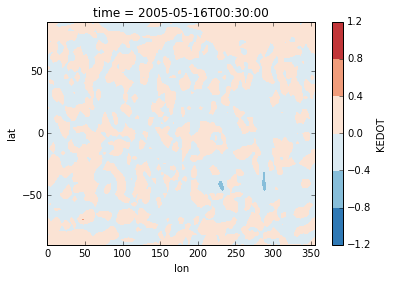

In [16]:
KEDOT.plot.contourf()

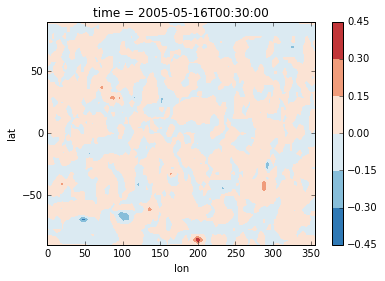

In [17]:
(SKEDOT-KEDOT).plot.contourf()

In [22]:
xr.merge([KEDOT,SKEDOT,SKE]).to_netcdf('/data2/suvarchal/G5NR/SKE_test.nc')